In [2]:
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

p_root = "/home/colombelli/Documents/datasets/LUNG_TEST_NPN_TRUNC/"
df0_name = "tcga_intersect.csv"
df1_name = "cumida1_intersect.csv"
df2_name = "cumida2_intersect.csv"
df3_name = "cumida3_intersect.csv"

In [3]:
df0 = pd.read_csv(p_root+df0_name, index_col=0)
df1 = pd.read_csv(p_root+df1_name, index_col=0)
df2 = pd.read_csv(p_root+df2_name, index_col=0)
df3 = pd.read_csv(p_root+df3_name, index_col=0)

In [5]:
def normalize_df(df):
    
    df_norm_vals = normalize(df.iloc[:, 0:-1])
    cols =  df.iloc[:, 0:-1].columns
    indexes = df.iloc[:, 0:-1].index
    
    df_norm = pd.DataFrame(df_norm_vals)
    df_norm.columns = cols
    df_norm.index = indexes
    df_norm['class'] = df['class']
    
    return df_norm

In [7]:
df0_norm = normalize_df(df0)
scaler = StandardScaler().fit(df0_norm.iloc[:, 0:-1])

In [8]:
def scale_df(df, save_path):
    
    df_scaled_vals = scaler.transform(df.iloc[:, 0:-1])
    cols =  df.iloc[:, 0:-1].columns
    indexes = df.iloc[:, 0:-1].index
    
    df_scaled = pd.DataFrame(df_scaled_vals)
    df_scaled.columns = cols
    df_scaled.index = indexes
    df_scaled['class'] = df['class']
    
    df_scaled.to_csv(save_path)
    print("Scaling completed for:", save_path)
    return

In [9]:
dfs = [df0,df1,df2,df3]
paths = [p_root+"tcga_scaled_and_normalized.csv",
         p_root+"cumida1_scaled_and_normalized.csv",
         p_root+"cumida2_scaled_and_normalized.csv",
         p_root+"cumida3_scaled_and_normalized.csv"]

In [10]:
for i, df in enumerate(dfs):
    df_n = normalize_df(df)
    scale_df(df_n, paths[i])

Scaling completed for: /home/colombelli/Documents/datasets/LUNG_TEST_NPN_TRUNC/tcga_scaled_and_normalized.csv
Scaling completed for: /home/colombelli/Documents/datasets/LUNG_TEST_NPN_TRUNC/cumida1_scaled_and_normalized.csv
Scaling completed for: /home/colombelli/Documents/datasets/LUNG_TEST_NPN_TRUNC/cumida2_scaled_and_normalized.csv
Scaling completed for: /home/colombelli/Documents/datasets/LUNG_TEST_NPN_TRUNC/cumida3_scaled_and_normalized.csv


## Box-plotting norm-scaled data

In [11]:
import seaborn as sns

def boxplot_df(df):
    x = sns.boxplot(data=df)
    x.set(xticklabels=[])
    x.tick_params(bottom=False)
    x.set(xlabel=None)
    return

In [12]:
df0 = pd.read_csv(paths[0], index_col=0)
df1 = pd.read_csv(paths[1], index_col=0)
df2 = pd.read_csv(paths[2], index_col=0)
df3 = pd.read_csv(paths[3], index_col=0)

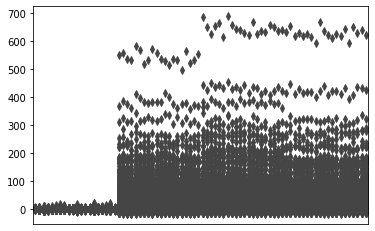

In [13]:
dfs = [df0,df1,df2,df3]
dfs20 = []
for df in dfs:
    df = df.sample(frac=1)
    dfs20.append(df.iloc[0:20, 0:-1])

dfConc = pd.concat([dfs20[0], dfs20[1], dfs20[2], dfs20[3]]).T
boxplot_df(dfConc)

In [14]:
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn import metrics


def get_x(df):
    return df.loc[:, df.columns != 'class']
    
def get_y(df):
    return df.loc[:, ['class']].T.values[0]

def get_probs_positive_class(pred):
        positive_probs = []

        for prediction in pred:
            positive_probs.append(prediction[1])
        return positive_probs
    

def load_dataframes(train_path, test_path):
    train_df = pd.read_csv(train_path, index_col=0)
    test_df = pd.read_csv(test_path, index_col=0)
    return train_df, test_df


def cross_testing_accuracy(train_df, test_df, genes_ranking_path, thresholds):
    gdf = pd.read_csv(genes_ranking_path, index_col=0)
    genes = list(gdf.index)
    
    for threshold in thresholds:
        print("Cross-testing with threshold:", threshold)
        #clf = SVC(gamma='auto', probability=True)
        clf = GBC()
        
        tr_top = train_df.loc[:, genes[0:threshold]+['class']]
        ts_top = test_df.loc[:, genes[0:threshold]+['class']]

        X_train = get_x(tr_top)
        y_train = get_y(tr_top)

        clf.fit(X_train, y_train)


        X_test = get_x(ts_top)
        y_test = get_y(ts_top)

        acc_score = clf.score(X_test, y_test)

        pred = clf.predict_proba(X_test)
        y_pred = np.argmax(pred, axis=1)
        pred = get_probs_positive_class(pred)

        roc_auc = metrics.roc_auc_score(np.array(y_test, dtype=int), pred)
        pred_accuracy = metrics.accuracy_score(y_test, y_pred)

        print("Accuracy with .score:", acc_score)
        print("Accuracy with .predict_proba:", pred_accuracy)
        print("ROC AUC:", roc_auc)
        print("Predictions:", y_pred)
        print("\n")

In [15]:
ths = [1, 5, 10, 15, 20, 50, 100]#, 1000, 5000, -1]
genes_rank = "/home/colombelli/Documents/experiments/Experiments22_ago/luad/hyb_borda_borda/selection/agg_ranking_th1.csv"

dfs = [df0, df1, df2, df3]
for df in dfs:
    df = df.sample(frac=1)

In [16]:
cross_testing_accuracy(df0, df1, genes_rank, ths)

Cross-testing with threshold: 1
Accuracy with .score: 0.5333333333333333
Accuracy with .predict_proba: 0.5333333333333333
ROC AUC: 0.6482213438735177
Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]


Cross-testing with threshold: 5
Accuracy with .score: 0.8
Accuracy with .predict_proba: 0.8
ROC AUC: 0.720602766798419
Predictions: [0 1 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0
 0 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Cross-testing with threshold: 10
Accuracy with .score: 0.8444444444444444
Accuracy with .predict_proba: 0.8444444444444444
ROC AUC: 0.9006916996047432
Predictions: [0 1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0
 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 

In [17]:
cross_testing_accuracy(df0, df2, genes_rank, ths)

Cross-testing with threshold: 1
Accuracy with .score: 0.6052631578947368
Accuracy with .predict_proba: 0.6052631578947368
ROC AUC: 0.7356834975369458
Predictions: [1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1
 0 1 0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 0
 0 0 0]


Cross-testing with threshold: 5
Accuracy with .score: 0.7982456140350878
Accuracy with .predict_proba: 0.7982456140350878
ROC AUC: 0.7658559113300494
Predictions: [1 1 0 0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


Cross-testing with threshold: 10
Accuracy with .score: 0.8245614035087719
Accuracy with .predict_proba: 0.8245614035087719
ROC AUC: 0.8592980295566504
Predictions: [1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1

In [18]:
cross_testing_accuracy(df0, df3, genes_rank, ths)

Cross-testing with threshold: 1
Accuracy with .score: 0.6041666666666666
Accuracy with .predict_proba: 0.6041666666666666
ROC AUC: 0.8932291666666666
Predictions: [1 0 1 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1]


Cross-testing with threshold: 5
Accuracy with .score: 0.6666666666666666
Accuracy with .predict_proba: 0.6666666666666666
ROC AUC: 0.4357638888888889
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0
 0 0 1 0 0 1 1 0 0 1 0]


Cross-testing with threshold: 10
Accuracy with .score: 0.6666666666666666
Accuracy with .predict_proba: 0.6666666666666666
ROC AUC: 0.8680555555555555
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0
 0 0 1 0 0 1 1 0 0 1 0]


Cross-testing with threshold: 15
Accuracy with .score: 0.8333333333333334
Accuracy with .predict_proba: 0.8333333333333334
ROC AUC: 0.875
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1

In [19]:
cross_testing_accuracy(df1, df2, genes_rank, ths)

Cross-testing with threshold: 1
Accuracy with .score: 0.47368421052631576
Accuracy with .predict_proba: 0.47368421052631576
ROC AUC: 0.46351600985221675
Predictions: [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1
 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0
 1 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1
 0 1 0]


Cross-testing with threshold: 5
Accuracy with .score: 0.5877192982456141
Accuracy with .predict_proba: 0.5877192982456141
ROC AUC: 0.604371921182266
Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1
 1 0 1]


Cross-testing with threshold: 10
Accuracy with .score: 0.6052631578947368
Accuracy with .predict_proba: 0.6052631578947368
ROC AUC: 0.603448275862069
Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 